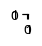

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.metrics import get_nested_feature_importance, plot_feature_importance, get_metrics
from src.utils import pkl_load, pkl_dump, get_palette
from src.bootstrap import bootstrap_eval, get_pval, plot_pval
from src.bootstrap import get_pval, plot_pval
from src.datasets import NNAlignDataset, get_NNAlign_dataloader
import torch
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180

# small dim tests

In [76]:
in_dim=21*23
hidden_dim=128
n_layers=2

layers = [nn.Linear(in_dim, in_dim//2), nn.ReLU()]
for n in range(n_layers-1):
    in_dim=in_dim//2
    layers.extend([nn.Linear(in_dim, in_dim//2), nn.ReLU()])
print(layers)

[Linear(in_features=483, out_features=241, bias=True), ReLU(), Linear(in_features=241, out_features=120, bias=True), ReLU()]


# Gliph first because it's shorter

In [29]:
# These are Mtb specific TCRs
gliph_bulk = pd.read_excel('../data/GLIPH/GLIPH2_Mtb_TCRs_41587_2020_505_MOESM3_ESM.xlsx', sheet_name = 'bulk TCR')
gliph_sc =  pd.read_excel('../data/GLIPH/GLIPH2_Mtb_TCRs_41587_2020_505_MOESM3_ESM.xlsx', sheet_name = 'single cell TCR')
gliph_sc.drop(columns=[x for x in gliph_sc.columns if 'Unnamed' in x and not '40' in x], inplace=True)

gliph_bulk['len_beta'] = gliph_bulk['CDR3b'].apply(len)
gliph_sc['len_beta'] = gliph_sc['CDR3beta'].apply(lambda x: len(x) if x is not np.nan else np.nan)
gliph_sc['len_alpha'] = gliph_sc['CDR3alpha'].apply(lambda x: len(x) if x is not np.nan else np.nan)

In [172]:
# 3264 TCRs in the GLIPH VDJdb
gliph_vdjdb = pd.read_excel('../data/GLIPH/GLIPH2_VDJdb_41587_2020_505_MOESM4_ESM.xlsx', header=None, names=['CDR3b', 'V', 'J', 'peptide'])
display(gliph_vdjdb.head()), print(len(gliph_vdjdb))

,CDR3b,V,J,peptide
0,CASTGSYGYTF,TRBV19*01,TRBJ1-2*01,KAFSPEVIPMF
1,CASSLTYGYTF,TRBV19*01,TRBJ1-2*01,KAFSPEVIPMF
2,CASSSRTGGYGYTF,TRBV19*01,TRBJ1-2*01,KAFSPEVIPMF
3,CATSDRMDNEQFF,TRBV24-1*01,TRBJ2-1*01,KAFSPEVIPMF
4,CASGGEFYGYTF,TRBV7-9*01,TRBJ1-2*01,KAFSPEVIPMF


3264


(None, None)

In [32]:
print(len(gliph_bulk))
display(gliph_bulk.head())

10501


,CDR3b,Vb,Jb,CDR3a,Va,Ja,Individual,Counts,len_beta
0,CASRDRGLSYEQYF,TRBV10-3,NaN,NaN,NaN,NaN,01/1016,1,14
1,CASRLGLAGLTQETQYF,TRBV5-1,NaN,NaN,NaN,NaN,01/1016,3,17
2,CASRPGLWGEQFF,TRBV28,NaN,NaN,NaN,NaN,01/1016,2,13
3,CASRQAGRDEQFF,TRBV6-1,NaN,NaN,NaN,NaN,01/1016,1,13
4,CASRSRGGRTYNEQFF,TRBV6-2,NaN,NaN,NaN,NaN,01/1016,2,16


In [33]:
print(len(gliph_sc))
display(gliph_sc.head())

8255


,Individual,Stim,Vbeta,Jbeta,CDR3beta,BetaConfi,BetaReads,Valpha,Jalpha,CDR3alpha,AlphaConfi,AlphaReads,2ndValpha,2ndJalpha,CDR3alpha2nd,Confi,Reads,Unnamed: 40,len_beta,len_alpha
0,01/1013,MtbLys,TRBV28,TRBJ2-7,CASMGQIYEQYF,0.928,5434.0,TRAV9-1,TRAJ57,CALSAQGGSEKLVF,0.924,4636.0,NaN,NaN,NaN,NaN,NaN,GCCCAGGGTTTTCCCAGTCACGACGGGGTACAGTGTCTCTAGAGAG...,12.0,14.0
1,01/1013,MtbLys,TRBV5-1,TRBJ1-3,CASSLESVSGNTIYF,0.932,4931.0,TRAV26-1,TRAJ56,CIVRVSGAGANSKLTF,0.619,2358.0,TRAV26-2,TRAJ43,NaN,0.273,1041.0,GCCCAGGGTTTTCCCAGTCACGACCGATTCTCAGGGCGCCAGTTCT...,15.0,16.0
2,01/1013,MtbLys,TRBV19,TRBJ1-6,CASKRDSQAYNSPLHF,0.928,4841.0,TRAV8-3,TRAJ27,CAANTNAGKSTF,0.910,5573.0,NaN,NaN,NaN,NaN,NaN,GCCCAGGGTTTTCCCAGTCACGACGGTACAGCGTCTCTCGGGAGAA...,16.0,12.0
3,01/1013,MtbLys,TRBV6-1,TRBJ2-7,CASSALQAYEQYF,0.925,5296.0,TRAV17,TRAJ52,NaN,0.996,3589.0,NaN,NaN,NaN,NaN,NaN,GCCCAGGGTTTTCCCAGTCACGACTGGCTACAATGTCTCCAGATTA...,13.0,NaN
4,01/1013,MtbLys,TRBV20-1,TRBJ2-3,CSARSPPDTQYF,0.941,5606.0,TRAV9-1,TRAJ39,CALSDRYNNAGNMLTF,0.896,3608.0,NaN,NaN,NaN,NaN,NaN,GCCCAGGGTTTTCCCAGTCACGACGGACAAGTTTCTCATCAACCAT...,12.0,16.0


In [34]:
gliph_bulk['seq_id'] = [f'seq_{i:05}' for i in range(1, len(gliph_bulk)+1)]
gliph_sc['seq_id'] = [f'seq_{i:05}' for i in range(1, len(gliph_sc)+1)]
gliph_bulk.to_csv('../data/GLIPH/230918_gliph_bulk.csv', index=False)
gliph_sc.to_csv('../data/GLIPH/230918_gliph_sc.csv', index=False)

In [72]:
gliph_merged_cdr3=pd.concat([gliph_bulk.assign(db='bulk').drop(columns=['Jb', 'CDR3a', 'Va', 'Ja']).rename(columns={'CDR3b':'CDR3beta', 'Vb':'Vbeta'}), 
           gliph_sc.assign(db='sc').drop(columns=[x for x in gliph_sc.columns if 'alpha' in x.lower()])]).dropna(subset='CDR3beta').reset_index(drop=True)
display(gliph_merged_cdr3.head()), print(len(gliph_merged_cdr3))

,CDR3beta,Vbeta,Individual,Counts,len_beta,seq_id,db,Stim,Jbeta,BetaConfi,BetaReads,Confi,Reads,Unnamed: 40
0,CASRDRGLSYEQYF,TRBV10-3,01/1016,1.0,14.0,seq_00001,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CASRLGLAGLTQETQYF,TRBV5-1,01/1016,3.0,17.0,seq_00002,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CASRPGLWGEQFF,TRBV28,01/1016,2.0,13.0,seq_00003,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CASRQAGRDEQFF,TRBV6-1,01/1016,1.0,13.0,seq_00004,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CASRSRGGRTYNEQFF,TRBV6-2,01/1016,2.0,16.0,seq_00005,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN


16663


(None, None)

In [73]:
gliph_merged_cdr3['flag'] = gliph_merged_cdr3['CDR3beta'].apply(lambda x: 'X' in x or '-' in x)
gliph_merged_cdr3.query('flag')
# Only keep the datapoints that don't have X
gliph_merged_cdr3.query('not flag').drop(columns='flag').reset_index(drop=True).to_csv('../data/GLIPH/230918_gliph_merged_cdr3beta.csv', index=False)

In [158]:
gliph_merged_cdr3 = pd.read_csv('../data/GLIPH/230918_gliph_merged_cdr3beta.csv')
len(gliph_merged_cdr3), len(gliph_merged_cdr3['CDR3beta'].unique())

(16652, 15048)

In [159]:
gliph_merged_cdr3

,CDR3beta,Vbeta,Individual,Counts,len_beta,seq_id,db,Stim,Jbeta,BetaConfi,BetaReads,Confi,Reads,Unnamed: 40
0,CASRDRGLSYEQYF,TRBV10-3,01/1016,1.0,14.0,seq_00001,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CASRLGLAGLTQETQYF,TRBV5-1,01/1016,3.0,17.0,seq_00002,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CASRPGLWGEQFF,TRBV28,01/1016,2.0,13.0,seq_00003,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CASRQAGRDEQFF,TRBV6-1,01/1016,1.0,13.0,seq_00004,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CASRSRGGRTYNEQFF,TRBV6-2,01/1016,2.0,16.0,seq_00005,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16647,CASSELEADTQYF,TRBV2,09/0334,NaN,13.0,seq_08249,sc,MtbLys,TRBJ2-3,0.934,7306.0,NaN,NaN,CTCCAGGGTTTTCCCAGTCACGACGCCTGATGGATCAAATTTCACT...
16648,CSVVEGFGSFEKRNTQYF,TRBV29-1,09/0334,NaN,18.0,seq_08250,sc,MtbLys,TRBJ2-3,0.904,5390.0,NaN,NaN,CTCCAGGGTTTTCCCAGTCACGACGTTTCCCATCAGCCGCCCAAAC...
16649,CASSSSPGSNSPLHF,TRBV9,09/0334,NaN,15.0,seq_08251,sc,MtbLys,TRBJ1-6,0.925,6794.0,NaN,NaN,CTCCAGGGTTTTCCCAGTCACGACCTCCGCACAACAGTTCCCTGAC...
16650,CASSPGQPGGYTF,TRBV27,09/0334,NaN,13.0,seq_08252,sc,MtbLys,TRBJ1-2,0.937,7678.0,NaN,NaN,CTCCAGGGTTTTCCCAGTCACGACTACAAAGTCTCTCGAAAAGAGA...


# DeepTCR

In [27]:
%ls ../data/DeepTCR/


10x_Data/             Human_Antigens/       Sidhom/
Dash_Human/           Human_HLA_Tutorial/   VDJ.tsv
Dash_Murine/          McPAS-TCR.csv         Zhang/
Glanville/            Murine_Antigens/      combine_vdj_mcpas.py
HIV/                  Rudqvist/             vdj_mcpas.csv


In [160]:
tenx = pd.read_csv('../data/DeepTCR/10x_Data/Data_Regression.csv')
display(tenx.head())
print(len(tenx))

,alpha,beta,A0101_VTEHDTLLY_IE-1_CMV,A0201_KTWGQYWQV_gp100_Cancer,A0201_ELAGIGILTV_MART-1_Cancer,A0201_CLLWSFQTSA_Tyrosinase_Cancer,A0201_IMDQVPFSV_gp100_Cancer,A0201_SLLMWITQV_NY-ESO-1_Cancer,A0201_KVAELVHFL_MAGE-A3_Cancer,A0201_KVLEYVIKV_MAGE-A1_Cancer,A0201_CLLGTYTQDV_Kanamycin-B-dioxygenase,A0201_LLDFVRFMGV_EBNA-3B_EBV,A0201_LLMGTLGIVC_HPV-16E7_82-91,A0201_CLGGLLTMV_LMP-2A_EBV,A0201_YLLEMLWRL_LMP1_EBV,A0201_FLYALALLL_LMP2A_EBV,A0201_GILGFVFTL_Flu-MP_Influenza,A0201_GLCTLVAML_BMLF1_EBV,A0201_NLVPMVATV_pp65_CMV,A0201_ILKEPVHGV_RT_HIV,A0201_FLASKIGRLV_Ca2-indepen-Plip-A2,A2402_CYTWNQMNL_WT1-(235-243)236M_Y,A0201_RTLNAWVKV_Gag-protein_HIV,A0201_KLQCVDLHV_PSA146-154,A0201_LLFGYPVYV_HTLV-1,A0201_SLFNTVATL_Gag-protein_HIV,A0201_SLYNTVATLY_Gag-protein_HIV,A0201_SLFNTVATLY_Gag-protein_HIV,A0201_RMFPNAPYL_WT-1,A0201_YLNDHLEPWI_BCL-X_Cancer,A0201_MLDLQPETT_16E7_HPV,A0301_KLGGALQAK_IE-1_CMV,A0301_RLRAEAQVK_EMNA-3A_EBV,A0301_RIAAWMATY_BCL-2L1_Cancer,A1101_IVTDFSVIK_EBNA-3B_EBV,A1101_AVFDRKSDAK_EBNA-3B_EBV,B3501_IPSINVHHY_pp65_CMV,A2402_AYAQKIFKI_IE-1_CMV,A2402_QYDPVAALF_pp65_CMV,B0702_QPRAPIRPI_EBNA-6_EBV,B0702_TPRVTGGGAM_pp65_CMV,B0702_RPPIFIRRL_EBNA-3A_EBV,B0702_RPHERNGFTVL_pp65_CMV,B0801_RAKFKQLL_BZLF1_EBV,B0801_ELRRKMMYM_IE-1_CMV,B0801_FLRGRAYGL_EBNA-3A_EBV,A0101_SLEGGGLGY_NC,A0101_STEGGGLAY_NC,A0201_ALIAPVHAV_NC,A2402_AYSSAGASI_NC,B0702_GPAESAAGL_NC,NR(B0801)_AAKGRGAAL_NC
0,CAAAAGEAGTYKYIF,CASSLEEGYSPLHF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CAAAANQAGTALIF,CASSFFVGGAEAFF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CAAAASDGQKLLF,CASTLPGQKQFF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CAAAAYNQGGKLIF,CATSDPAGMTGGWHGYTF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,11.0,0.0,7.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,CAAADNYGQNFVF,CAWSSGEGTDTQYF,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,17.0,1.0,5.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


57228


In [78]:
vdj_mcpas = pd.read_csv('../data/DeepTCR/vdj_mcpas.csv')
vdj_mcpas

,epitope,cdr3
0,LLWNGPMAV,CASSYSRTGSYEQYF
1,LLWNGPMAV,CASSQGLAYEQFF
2,LLWNGPMAV,CASSVEGPGELFF
3,LLWNGPMAV,CASSEATGASYEQYF
4,LLWNGPMAV,CASSEYVQYYGYTF
...,...,...
47292,SFHSLHLLF,CASSPPRLRDTQYF
47293,SFHSLHLLF,CISVPAARTGHRTQYF
47294,SFHSLHLLF,CASRPDRDNNYGFGF
47295,SFHSLHLLF,CASRPERDNNCF


# NetTCR data

In [81]:
%ls ../data/NetTCR

anarci_annotated_new_df.csv  new_train_df.csv
covid_controls/


In [119]:
nettcr_train = pd.read_csv('../data/NetTCR/new_train_df.csv').rename(columns={'CDR3a':'A3', 'CDR3b':'B3'}).drop(columns=['Unnamed: 0'])

In [153]:
nettcr_train.peptide.unique()

array(['ELAGIGILTV', 'RAKFKQLL', 'GLCTLVAML', 'GILGFVFTL', 'IVTDFSVIK',
       'NLVPMVATV'], dtype=object)

In [112]:
pd.set_option('display.max_columns',333)
nettcr_train.head()

,A1,A2,A3,B1,B2,B3,v_alpha,j_alpha,v_beta,j_beta,peptide,allele,origin,binder,partition,len_A1,len_A2,len_A3,len_B1,len_B2,len_B3
0,YKTSINNL,IRSNERE,CATSPHYGNNRLAF,DPISGHTAL,YFQGNSAPDKSGLPSDRFS,CASSLAPYTASTDTQYF,TRAV17*01,TRAJ7*01,TRBV7-2*01,TRBJ2-3*01,ELAGIGILTV,HLA-A*02:01,true_neg,0,5,8,7,14,9,19,17
1,YSDRGSQSF,IYSNGD,CAVSGNAGNMLTF,DPISEHNRL,YFQNEAQLEKSRLLSDRFS,CASSLAPGQGLYEQYF,TRAV12-2*01,TRAJ39*01,TRBV7-9*01,TRBJ2-7*01,RAKFKQLL,HLA-B*08:01,true_neg,0,0,9,6,13,9,19,16
2,YSVSGNPYL,YITGDNL,CAVRARSNDYKLSF,DPISEHNRL,YFQNEAQLEKSRLLSDRFS,CASSSQGGGGTDTQYF,TRAV3*01,TRAJ20*01,TRBV7-9*01,TRBJ2-3*01,RAKFKQLL,HLA-B*08:01,true_neg,0,3,9,7,14,9,19,16
3,YKTSINNL,IRSNERE,CALRRGYGNNRLAF,VQDMDHENM,FSYDVKMKEKGDIPEGYS,CASSSWDIQTNTGELFF,TRAV17*01,TRAJ7*01,TRBV28*01,TRBJ2-2*01,RAKFKQLL,HLA-B*08:01,swapped,0,1,8,7,14,9,18,17
4,YQTSGFNGL,NVLDGL,CAVRDKTDKLIF,RSLDFQATTM,TSNEGSKATYEQGVEKDKFL,CSAWGQAYGYEQYF,TRAV1-2*01,TRAJ34*01,TRBV20-1*01,TRBJ2-7*01,ELAGIGILTV,HLA-A*02:01,true_neg,0,4,9,6,12,10,20,14


In [135]:
for c in ['A1', 'A2', 'A3', 'B1', 'B2', 'B3']:
    nettcr_train[f'len_{c}'] = nettcr_train[c].apply(len)
    nettcr_train[f'flag_{c}'] = nettcr_train[c].apply(lambda z:any(['X' in x or '-' in x or '*' in x for x in z]))

lens = [f'len_{c}' for c in ['A1', 'A2', 'A3', 'B1', 'B2', 'B3']] 
flags = [f'flag_{c}' for c in ['A1', 'A2', 'A3', 'B1', 'B2', 'B3']]

In [109]:
nettcr_train[[x for x in nettcr_train.columns if 'len' in x]].describe()

,len_A1,len_A2,len_A3,len_B1,len_B2,len_B3
count,28088.000000,28088.000000,28088.000000,28088.00000,28088.000000,28088.000000
mean,9.021967,6.690188,13.598085,9.07124,18.442467,14.394617
std,0.596134,0.904765,1.960316,0.25806,0.669436,1.688912
min,8.000000,3.000000,6.000000,8.00000,17.000000,7.000000
25%,9.000000,6.000000,12.000000,9.00000,18.000000,13.000000
50%,9.000000,7.000000,14.000000,9.00000,18.000000,14.000000
75%,9.000000,7.000000,15.000000,9.00000,19.000000,15.000000
max,10.000000,8.000000,20.000000,10.00000,20.000000,20.000000


In [140]:
nettcr_train.head()

,A1,A2,A3,B1,B2,B3,v_alpha,j_alpha,v_beta,j_beta,peptide,allele,origin,binder,partition,flag,len_A1,flag_A1,len_A2,flag_A2,len_A3,flag_A3,len_B1,flag_B1,len_B2,flag_B2,len_B3,flag_B3
0,YKTSINNL,IRSNERE,CATSPHYGNNRLAF,DPISGHTAL,YFQGNSAPDKSGLPSDRFS,CASSLAPYTASTDTQYF,TRAV17*01,TRAJ7*01,TRBV7-2*01,TRBJ2-3*01,ELAGIGILTV,HLA-A*02:01,true_neg,0,5,False,8,False,7,False,14,False,9,False,19,False,17,False
1,YSDRGSQSF,IYSNGD,CAVSGNAGNMLTF,DPISEHNRL,YFQNEAQLEKSRLLSDRFS,CASSLAPGQGLYEQYF,TRAV12-2*01,TRAJ39*01,TRBV7-9*01,TRBJ2-7*01,RAKFKQLL,HLA-B*08:01,true_neg,0,0,False,9,False,6,False,13,False,9,False,19,False,16,False
2,YSVSGNPYL,YITGDNL,CAVRARSNDYKLSF,DPISEHNRL,YFQNEAQLEKSRLLSDRFS,CASSSQGGGGTDTQYF,TRAV3*01,TRAJ20*01,TRBV7-9*01,TRBJ2-3*01,RAKFKQLL,HLA-B*08:01,true_neg,0,3,False,9,False,7,False,14,False,9,False,19,False,16,False
3,YKTSINNL,IRSNERE,CALRRGYGNNRLAF,VQDMDHENM,FSYDVKMKEKGDIPEGYS,CASSSWDIQTNTGELFF,TRAV17*01,TRAJ7*01,TRBV28*01,TRBJ2-2*01,RAKFKQLL,HLA-B*08:01,swapped,0,1,False,8,False,7,False,14,False,9,False,18,False,17,False
4,YQTSGFNGL,NVLDGL,CAVRDKTDKLIF,RSLDFQATTM,TSNEGSKATYEQGVEKDKFL,CSAWGQAYGYEQYF,TRAV1-2*01,TRAJ34*01,TRBV20-1*01,TRBJ2-7*01,ELAGIGILTV,HLA-A*02:01,true_neg,0,4,False,9,False,6,False,12,False,10,False,20,False,14,False


In [115]:
nettcr_train.groupby(['peptide', 'binder']).count()

A1    A2    A3    B1    B2    B3  v_alpha  j_alpha  \
peptide    binder                                                         
ELAGIGILTV 0       3805  3805  3805  3805  3805  3805     3805     3805   
           1        316   316   316   316   316   316      316      316   
GILGFVFTL  0       6451  6451  6451  6451  6451  6451     6451     6451   
           1        969   969   969   969   969   969      969      969   
GLCTLVAML  0       3258  3258  3258  3258  3258  3258     3258     3258   
           1        173   173   173   173   173   173      173      173   
IVTDFSVIK  0       3640  3640  3640  3640  3640  3640     3640     3640   
           1        275   275   275   275   275   275      275      275   
NLVPMVATV  0       3217  3217  3217  3217  3217  3217     3217     3217   
           1        149   149   149   149   149   149      149      149   
RAKFKQLL   0       5176  5176  5176  5176  5176  5176     5176     5176   
           1        659   659   659   659   659   659      659      659   

                   v_beta  j_beta  allele  origin  partition  len_A1  len_A2  \
peptide    binder                                                              
ELAGIGILTV 0         3805    3805    3805    3805       3805    3805    3805   
           1          316     316     316     316        316     316     316   
GILGFVFTL  0         6451    6451    6451    6451       6451    6451    6451   
           1          969     969     969     969        969     969     969   
GLCTLVAML  0         3258    3258    3258    3258       3258    3258    3258   
           1          173     173     173     173        173     173     173   
IVTDFSVIK  0         3640    3640    3640    3640       3640    3640    3640   
           1          275     275     275     275        275     275     275   
NLVPMVATV  0         3217    3217    3217    3217       3217    3217    3217   
           1          149     149     149     149        149     149     149   
RAKFKQLL   0         5176    5176    5176    5176       5176    5176    5176   
           1          659     659     659     659        659     659     659   

                   len_A3  len_B1  len_B2  len_B3  
peptide    binder                                  
ELAGIGILTV 0         3805    3805    3805    3805  
           1          316     316     316     316  
GILGFVFTL  0         6451    6451    6451    6451  
           1          969     969     969     969  
GLCTLVAML  0         3258    3258    3258    3258  
           1          173     173     173     173  
IVTDFSVIK  0         3640    3640    3640    3640  
           1          275     275     275     275  
NLVPMVATV  0         3217    3217    3217    3217  
           1          149     149     149     149  
RAKFKQLL   0         5176    5176    5176    5176  
           1          659     659     659     659

In [173]:
nettcr_new = pd.read_csv('../data/NetTCR/nettcr_train_mathias.csv')
display(nettcr_new.head()), print(len(nettcr_new))

,Unnamed: 0,A1,A2,A3,B1,B2,B3,peptide,allele,origin,binder,partition,original_peptide,original_index
0,0,KALYS,LLKGGEQ,GTEIGGGTSYGKLT,MNHEY,SMNVEV,ASGTETQY,SPRWYFYYL,HLA-B*07:02,peptide_swapped,0,2,KLGGALQAK,2627
1,1,DRGSQS,IYSNGD,AVNPANARLM,DFQATT,SNEGSKA,SARWGGGTDTQY,GILGFVFTL,HLA-A*02:01,peptide_swapped,0,3,ELAGIGILTV,3820
2,2,TSGFNG,NVLDGL,AVGDDKII,DFQATT,SNEGSKA,SARGLDRGTNEQY,KLGGALQAK,HLA-A*03:01,peptide_swapped,0,3,AVFDRKSDAK,3592
3,3,DRGSQS,IYSNGD,AVTPGTYKYI,LGHDT,YNNKEL,ASSPGTSIFVAEQY,KLGGALQAK,HLA-A*03:01,peptide_swapped,0,0,ELAGIGILTV,5933
4,4,TRDTTYY,RNSFDEQN,AFLYNQGGKLI,SGHDY,FNNNVP,ASSPGSRGNIQY,CINGVCWTV,HLA-A*02:01,peptide_swapped,0,1,RAKFKQLL,2745


37721


(None, None)

In [175]:
nettcr_new.origin.unique()

array(['peptide_swapped', 'IEDB', 'VDJdb', '10x'], dtype=object)

In [176]:
nettcr_new.query('B3=="SARWGGGTDTQY"')

,Unnamed: 0,A1,A2,A3,B1,B2,B3,peptide,allele,origin,binder,partition,original_peptide,original_index
1,1,DRGSQS,IYSNGD,AVNPANARLM,DFQATT,SNEGSKA,SARWGGGTDTQY,GILGFVFTL,HLA-A*02:01,peptide_swapped,0,3,ELAGIGILTV,3820
3302,3302,DRGSQS,IYSNGD,AVNPANARLM,DFQATT,SNEGSKA,SARWGGGTDTQY,AVFDRKSDAK,HLA-A*11:01,peptide_swapped,0,3,ELAGIGILTV,3820
3414,3414,TRDTTYY,RNSFDEQN,ALSVFSGGGADGLT,DFQATT,SNEGSKA,SARWGGGTDTQY,GILGFVFTL,HLA-A*02:01,peptide_swapped,0,2,RAKFKQLL,6339
5034,5034,DRGSQS,IYSNGD,AVNPANARLM,DFQATT,SNEGSKA,SARWGGGTDTQY,SPRWYFYYL,HLA-B*07:02,peptide_swapped,0,3,ELAGIGILTV,3820
6157,6157,DRGSQS,IYSNGD,AVNPANARLM,DFQATT,SNEGSKA,SARWGGGTDTQY,CINGVCWTV,HLA-A*02:01,peptide_swapped,0,3,ELAGIGILTV,3820
10407,10407,DRGSQS,IYSNGD,AVNPANARLM,DFQATT,SNEGSKA,SARWGGGTDTQY,RAKFKQLL,HLA-B*08:01,peptide_swapped,0,3,ELAGIGILTV,3820
11935,11935,DSSSTY,IFSNMDM,AELKEKLI,DFQATT,SNEGSKA,SARWGGGTDTQY,KLGGALQAK,HLA-A*03:01,peptide_swapped,0,1,GLCTLVAML,2605
15889,15889,DRGSQS,IYSNGD,AVNPANARLM,DFQATT,SNEGSKA,SARWGGGTDTQY,NLVPMVATV,HLA-A*02:01,peptide_swapped,0,3,ELAGIGILTV,3820
19661,19661,DRGSQS,IYSNGD,AVNPANARLM,DFQATT,SNEGSKA,SARWGGGTDTQY,KLGGALQAK,HLA-A*03:01,peptide_swapped,0,3,ELAGIGILTV,3820
21523,21523,TRDTTYY,RNSFDEQN,ALSVFSGGGADGLT,DFQATT,SNEGSKA,SARWGGGTDTQY,KLGGALQAK,HLA-A*03:01,peptide_swapped,0,2,RAKFKQLL,6339


In [218]:
immrep_negs = pd.read_csv('../data/NetTCR/negative_controls_95_redundancy_reduced.csv').assign(peptide='true_neg', original_peptide='true_neg')
display(immrep_negs.head()), print(len(immrep_negs))

,A1,A2,A3,B1,B2,B3,binder,peptide,original_peptide
0,NSASDY,IRSNMDK,AERPGGKLI,SGHAT,FQNNGV,ASSYQGNEAF,0,true_neg,true_neg
1,TISGNEY,GLKNN,IVRVGGSQGNLI,DFQATT,SNEGSKA,SARGPATNEKLF,0,true_neg,true_neg
2,TRDTTYY,RNSFDEQN,ALSDPALKAAGNKLT,MNHEY,SMNVEV,ASSFFSGGWNEQF,0,true_neg,true_neg
3,TSENNYY,QEAYKQQN,AFMNPNYQLI,SGDLS,YYNGEE,ASSAPDRPGNEQY,0,true_neg,true_neg
4,YGGTVN,YFSGDPLV,LRGLDTGFQKLV,SGDLS,YYNGEE,ASSPYRDSQETQY,0,true_neg,true_neg


14864


(None, None)

In [237]:
from sklearn.model_selection import KFold
def get_kfolds(df, k, xcol, ycol, shuffle=False, random_state=None):
    """ Splits & assigns the fold numbers
    Args:
        df:
        k:
        shuffle:
        random_state:

    Returns:
        df: df with column fold according to the Kfolds
    """
    kf = KFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    df['partition'] = -1
    for i, (train_idx, test_idx) in enumerate(kf.split(df[xcol].values, df[ycol])):
        df.iloc[test_idx, df.columns.get_loc('partition')] = i
    df.partition = df.partition.astype(int)
    return df

immrep_negs = get_kfolds(immrep_negs, k=5, xcol='B3', ycol='binder', shuffle=True, random_state=13)

In [243]:
pd.concat([immrep_negs, nettcr_new.query('origin!="peptide_swapped"')]).to_csv('../data/NetTCR/230919_nettcr_immrepnegs_noswap.csv', index=False)

In [248]:
pd.concat([immrep_negs, nettcr_new]).drop_duplicates(['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'peptide']).to_csv('../data/NetTCR/230919_nettcr_immrepnegs_merged_all.csv',

,A1,A2,A3,B1,B2,B3,binder,peptide,original_peptide,partition,Unnamed: 0,allele,origin,original_index
0,NSASDY,IRSNMDK,AERPGGKLI,SGHAT,FQNNGV,ASSYQGNEAF,0,true_neg,true_neg,3,NaN,NaN,NaN,NaN
1,TISGNEY,GLKNN,IVRVGGSQGNLI,DFQATT,SNEGSKA,SARGPATNEKLF,0,true_neg,true_neg,2,NaN,NaN,NaN,NaN
2,TRDTTYY,RNSFDEQN,ALSDPALKAAGNKLT,MNHEY,SMNVEV,ASSFFSGGWNEQF,0,true_neg,true_neg,4,NaN,NaN,NaN,NaN
3,TSENNYY,QEAYKQQN,AFMNPNYQLI,SGDLS,YYNGEE,ASSAPDRPGNEQY,0,true_neg,true_neg,1,NaN,NaN,NaN,NaN
4,YGGTVN,YFSGDPLV,LRGLDTGFQKLV,SGDLS,YYNGEE,ASSPYRDSQETQY,0,true_neg,true_neg,3,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37716,DSAIYN,IQSSQRE,AVHGYGQNFV,SQVTM,ANQGSEA,SAGGNTEAF,0,AVFDRKSDAK,RAKFKQLL,3,37716.0,HLA-A*11:01,peptide_swapped,883.0
37717,VSGNPY,YITGDNLV,AVRERNAGNNRKLI,DFQATT,SNEGSKA,SARGADTQY,0,LLWNGPMAV,NLVPMVATV,1,37717.0,HLA-A*02:01,peptide_swapped,1895.0
37718,NSAFQY,TYSSGN,AMNGARLMFGD,DFQATT,SNEGSKA,SARDVLAGGSDTQYFG,0,KLGGALQAK,NLVPMVATV,3,37718.0,HLA-A*03:01,peptide_swapped,5763.0
37719,SIFNT,LYKAGEL,AGQTTSNTGKLI,DFQATT,SNEGSKA,SASQDPYEQY,0,RAKFKQLL,DATYQRTRALVR,3,37719.0,HLA-B*08:01,peptide_swapped,3841.0


# COVID AdaptiveBiotech dataset

In [161]:
%ls ../data/covid_ada_002/

ImmuneCODE-MIRA-Release002.1/          ImmuneCODE-Repertoires-002.2/
ImmuneCODE-Repertoire-Tags-002.2.tsv   ImmuneCODE-Repertoires-002.tgz
ImmuneCODE-Repertoire-Tags-002.2.xlsx


In [163]:
%ls ../data/covid_ada_002/ImmuneCODE-Repertoires-002.2/ | head

1044BW_20200414_Unenr_immunoSEQ_TCRB.tsv
1349BW_unsorted_cc1000000_ImmunRACE_043020_003_gDNA_TCRB.tsv
1588BW_20200417_PBMC_unsorted_cc1000000_ImmunRACE_050820_008_gDNA_TCRB.tsv
1684BW_20200520_Unenr_gDNA_ImmunoSEQ_TCRB.tsv
1811BW_20200520_Unenr_gDNA_ImmunoSEQ_TCRB.tsv
1886BW_unsorted_cc1000000_ImmunRACE_043020_004_gDNA_TCRB.tsv
1979BW_20200420_PBMC_unsorted_cc1000000_ImmunRACE_052220_005_TCRB.tsv
1995BW_20200520_Unenr_gDNA_ImmunoSEQ_TCRB.tsv
2513BW_20200417_PBMC_unsorted_cc1000000_ImmunRACE_050820_006_gDNA_TCRB.tsv
2742BW_20200420_PBMC_unsorted_cc1000000_ImmunRACE_052220_004_TCRB.tsv


In [164]:
%ls ../data/covid_ada_002/ImmuneCODE-MIRA-Release002.1/ | head

minigene-detail.csv
minigene-hits.csv
orfs.csv
peptide-detail-ci.csv
peptide-detail-cii.csv
peptide-hits-ci.csv
peptide-hits-cii.csv
readme.txt
subject-metadata.csv


In [169]:
sorted(pd.read_csv('../data/covid_ada_002/ImmuneCODE-Repertoire-Tags-002.2.tsv', sep = '\t').columns)

['Age',
 'Biological Sex',
 'Dataset',
 'Ethnic Group',
 'HLA MHC class I',
 'HLA MHC class II',
 'ImmuneCODERelease',
 'Racial Group',
 'Tissue Source',
 'Virus Diseases',
 'abnormal_test_list',
 'ace_inhibitor_type',
 'ambulatory_limitation',
 'arb_type',
 'birth_year',
 'blood_oxygenation_percent_average',
 'blood_oxygenation_percent_max',
 'blood_oxygenation_percent_min',
 'blood_type',
 'cancer_diagnosed',
 'cancer_type',
 'chest_xray_ct_results',
 'cigarette_pack_years',
 'cmv_at_donation',
 'cohort',
 'collection_region',
 'covid_abnormal_imaging',
 'covid_abnormal_test_results',
 'covid_category',
 'covid_diagnosis',
 'covid_diagnosis_location',
 'covid_diagnosis_method',
 'covid_exposed',
 'covid_pcr_test_result_positive',
 'covid_pcr_test_type',
 'covid_pneumonia',
 'covid_quarantine',
 'covid_recovered',
 'covid_symptoms_current',
 'covid_symptoms_total',
 'covid_unit_admit',
 'covid_visit',
 'current_medications',
 'days_from_cancer_diagnosis_to_sample',
 'days_from_diagnos

In [178]:
rep1 = pd.read_csv('../data/covid_ada_002/ImmuneCODE-Repertoires-002.2/1044BW_20200414_Unenr_immunoSEQ_TCRB.tsv', sep = '\t')
rep1.head()

,rearrangement,extended_rearrangement,bio_identity,amino_acid,templates,frame_type,rearrangement_type,productive_frequency,cdr1_start_index,cdr1_rearrangement_length,cdr2_start_index,cdr2_rearrangement_length,cdr3_start_index,cdr3_length,v_index,n1_index,d_index,n2_index,j_index,v_deletions,n2_insertions,d3_deletions,d5_deletions,n1_insertions,j_deletions,chosen_j_allele,chosen_j_family,chosen_j_gene,chosen_v_allele,chosen_v_family,chosen_v_gene,d_allele,d_allele_ties,d_family,d_family_ties,d_gene,d_gene_ties,d_resolved,j_allele,j_allele_ties,j_family,j_family_ties,j_gene,j_gene_ties,j_resolved,v_allele,v_allele_ties,v_family,v_family_ties,v_gene,v_gene_ties,v_resolved
0,ACATCGGCCCAAAAGAACCCGACAGCTTTCTATCTCTGTGCCAGTA...,ATGAGCAACCAGGTGCTCTGCTGTGTGGTCCTTTGTTTCCTGGGAG...,CASSIAAADNSPLHF+TCRBV19-01+TCRBJ01-06,CASSIAAADNSPLHF,98,In,VDJ,0.001224984687691404,135,15,201,18,327,45,36,52,55,58,61,1,3,5,4,3,5,02,TCRBJ01,06,01,TCRBV19,01,unknown,no data,unknown,"TCRBD01,TCRBD02",unresolved,"TCRBD01-01,TCRBD02-01",unknown,02,no data,TCRBJ01,no data,TCRBJ01-06,no data,TCRBJ01-06*02,01,no data,TCRBV19,no data,TCRBV19-01,no data,TCRBV19-01*01
1,CTGACTGTGAGCAACATGAGCCCTGAAGACAGCAGCATATATCTCT...,ATGCTGAGTCTTCTGCTCCTTCTCCTGGGACTAGGCTCTGTGTTCA...,CSANLQGTEAFF+TCRBV29-01+TCRBJ01-01,CSANLQGTEAFF,28,In,VDJ,3.499956250546868E-4,123,15,189,21,321,36,45,53,59,-1,66,6,6,2,3,no data,5,01,TCRBJ01,01,03,TCRBV29,01,01,no data,TCRBD01,no data,TCRBD01-01,no data,TCRBD01-01*01,01,no data,TCRBJ01,no data,TCRBJ01-01,no data,TCRBJ01-01*01,03,no data,TCRBV29,no data,TCRBV29-01,no data,TCRBV29-01*03
2,GTGACATCGGCCCAAAAGAACCCGACAGCTTTCTATCTCTGTGCCA...,ATGAGCAACCAGGTGCTCTGCTGTGTGGTCCTTTGTTTCCTGGGAG...,CASSKTGLSYEQYF+TCRBV19-01+TCRBJ02-07,CASSKTGLSYEQYF,3,In,VDJ,3.74995312558593E-5,135,15,201,18,327,42,39,52,53,59,62,4,1,4,2,3,no data,01,TCRBJ02,07,01,TCRBV19,01,01,no data,TCRBD01,no data,TCRBD01-01,no data,TCRBD01-01*01,01,no data,TCRBJ02,no data,TCRBJ02-07,no data,TCRBJ02-07*01,01,no data,TCRBV19,no data,TCRBV19-01,no data,TCRBV19-01*01
3,GTGACATCGGCCCAAAAGAACCCGACAGCTTTCTATCTCTGTGCCA...,ATGAGCAACCAGGTGCTCTGCTGTGTGGTCCTTTGTTTCCTGGGAG...,CASSSGLAPYEQYF+TCRBV19-01+TCRBJ02-07,CASSSGLAPYEQYF,14,In,VDJ,1.749978125273434E-4,135,15,201,18,327,42,39,51,53,62,64,5,2,7,no data,2,2,01,TCRBJ02,07,01,TCRBV19,01,unknown,"01,02",TCRBD02,no data,TCRBD02-01,no data,TCRBD02-01,01,no data,TCRBJ02,no data,TCRBJ02-07,no data,TCRBJ02-07*01,01,no data,TCRBV19,no data,TCRBV19-01,no data,TCRBV19-01*01
4,GCCAGGCCCTCACATACCTCTCAGTACCTCTGTGCCAGCCAACTCT...,ATGACTATCAGGCTCCTCTGCTACATGGGCTTTTATTTTCTGGGGG...,CASQLSGSLSGANVLTF+TCRBV25-01+TCRBJ02-06,CASQLSGSLSGANVLTF,23,In,VDJ,2.874964062949213E-4,135,15,201,18,327,51,30,39,46,51,56,8,7,3,4,5,no data,01,TCRBJ02,06,01,TCRBV25,01,01,no data,TCRBD01,no data,TCRBD01-01,no data,TCRBD01-01*01,01,no data,TCRBJ02,no data,TCRBJ02-06,no data,TCRBJ02-06*01,01,no data,TCRBV25,no data,TCRBV25-01,no data,TCRBV25-01*01


In [188]:
rep1.query('productive_frequency !="na"')[['productive_frequency']].astype(float).sort_values('productive_frequency', ascending=False)

,productive_frequency
4771,0.018725
3270,0.013900
1020,0.011900
150,0.011250
330,0.008350
...,...
25877,0.000012
25878,0.000012
25881,0.000012
25883,0.000012
